# Single-Network Models

Probably the easiest kinds of statistical models for us to think about are the *single-network models*. These types of models (like the name imples) describe the random processes which you'd find when you're only looking at one network. We can have models which assume all of the nodes connect to each other essentially randomly, models which assume that the nodes are in distinct *communities*, and many more.

The important realization to make about statistical models is that a model is *not* a network: it's the random process that *creates* a network. You can sample from a model a bunch of times, and because it's a random process, you'll end up with networks that look a little bit different each time -- but if you sampled a lot of networks and then averaged them, then you'd likely be able to get a reasonable ballpark estimation of what the model that they come from looks like.  

Let's pretend that we have a network, and the network is unweighted (meaning, we only have edges or not-edges) and undirected (meaning, edges connect nodes both ways). It'd have an adjacency matrix which consists of only 1's and 0's, because the only information we care about is whether there's an edge or not. The model that generated this network is pretty straightforward: there's just some universal probability that each node connects to each other node, and there are 10 nodes.

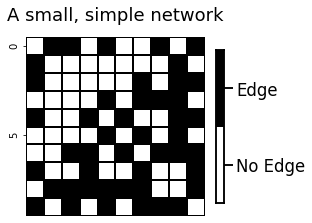

In [25]:
import matplotlib.pyplot as plt
from graspologic.simulations import er_np
from graspologic.plot import binary_heatmap

fig, ax = plt.subplots(figsize=(4,4))
n = 10
p = .5
A = er_np(n, p)
binary_heatmap(A, ax=ax, yticklabels=5, linewidths=1, linecolor="black", title="A small, simple network");

This small, simple network is one of many possible networks that we can generate with this model. Here are some more:

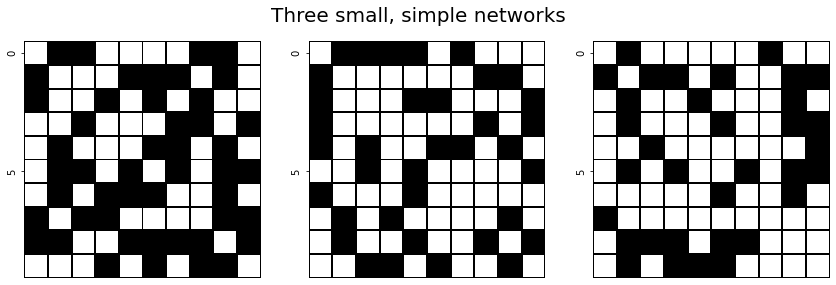

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ax in axs.flat:
    A = er_np(n, p)
    hmap = binary_heatmap(A, ax=ax, yticklabels=5, linewidths=1, linecolor="black", cbar=False)
plt.suptitle("Three small, simple networks", fontsize=20)
plt.tight_layout()

One reasonable question to ask is how *many* possible networks we could make in this simple scenario? We've already made four, and it seems like there are more that this model could potentially generate.

As it turns out, "more" is a pretty massive understatement. To actually figure out the number, think about the first node: there are two possibilities (weighted or not weighted), so you can generate two networks from a one-node model. Now, let's add an additional node. For each of the first two possibilities, there are two more -- so there are $2 \times 2 = 4$ total possible networks. Every node that we add doubles the number of networks - and since a network with $n$ nodes has $n \times n$ edges, the total number of possible networks ends up being $2^{n \times n} = 2^{n^2}$! So this ten-node model can generate $2^{10^2} = 2^{100}$ networks, which is, when you think carefully, an absurdly, ridiculously big number.

## Theory

To understand network models, it is crucial to understand the concept of the distribution of a network. We have a realization $A$, and we think that this realization is random in some way. Stated another way, we think that there exists a network-valued random variable $\mathbf A$ that governs the realizations we get to see. Since $\mathbf A$ is a random variable, we can describe it using a probability distribution. The distribution of the network topology is the function $\mathbb P$ which, if $\mathbf A$ is an unweighted random network with $n$ edges, assigns probabilities to every possible configuration that $\mathbf A$ could take. Notationally, we write that $\mathbf A \sim \mathbb P$, which is read in words as "the random network $\mathbf A$ is distributed according to $\mathbb P$." 

In the preceding description, we made a fairly substantial claim: $P$ assigns probabilities to every possible configuration that realizations of $\mathbf A$, denoted by $A$, could take. How many possibilities are there for a network with $n$ edges? Let's limit ourselves to simple networks: that is, $A$ takes values that are unweighted, undirected, and loopless (no self-connections). Formally, we describe $\mathcal A_n$ as:
\begin{align*}
    \mathcal A_n \triangleq \left\{A : A \in \{0, 1\}^{n \times n}, A = A^\top, diag(A) = 0\right\}
\end{align*}
In words, $\mathcal A_n$ is the set of all possible adjacency matrices $A$ that correspond to simple networks with $n$ nodes. To summarize the statement that $\mathbb P$ assigns probabilities to every possible configuration that realizations of $\mathbf A$ can take, we write that $\mathbb P : \mathcal A_n \rightarrow [0, 1]$. This means that for any $A \in \mathcal A_n$ which is a possible realization of $\mathbf A$, that $\mathbb P(\mathbf A = A)$ is a probability (it takes a value between $0$ and $1$). If it is completely unambiguous what the random variable $\mathbf A$ refers to, we might use the short-hand $\mathbb P(\mathbf A = A) \equiv \mathbb P(A)$. This statement can alternatively be read that the probability that the random variable $\mathbf A$ takes the value $A$ is $\mathbb P(A)$. Finally, let's address that question we had in the previous paragraph. How many possible adjacency matrices are in $\mathcal A_n$? 

Let's imagine what just one $A \in \mathcal A_n$ can look like. Note that each matrix $A$ has $n \times n = n^2$ possible entries, in total. As there are no diagonal entries to our matrix $A$, this means that there are $n^2 - n = n(n - 1)$ values that are definitely not $0$ in $A$, since there are $n$ diagonal entries of $A$.  As the transposes are the same, for every $a_{ij}$, we will also *double count* the $a_{ji}$ entry. This means that $A$ has a total of $\frac{1}{2}n(n - 1)$ possible entries which are randomly determined, which is equal to the expression $\binom{n}{2}$. Finally, note that for each entry of $A$ which is randomly determined, that the adjacency can take one of $2$ possible values: $0$ or $1$. Therefore, there are a total of $2^{\binom n 2}$ unique adjacency matrices in $\mathcal A_n$. Stated another way, the *cardinality* of $\mathcal A_n$, described by the expression $|\mathcal A_n|$, is $2^{\binom n 2}$. When $n$ is just $15$, note that $\left|\mathcal A_{15}\right| = 2^{\binom{15}{2}} = 2^{105}$, which is more than $10^{30}$ possible networks that can be realized! As $n$ increases, how many unique possible networks are there?

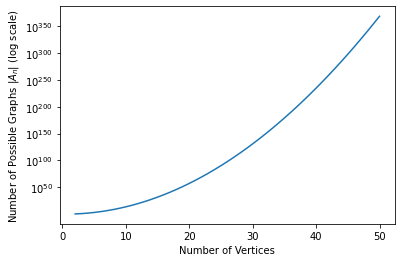

In [4]:
import seaborn as sns
import numpy as np
from math import comb


n = np.arange(2, 51)
logAn = np.array([comb(ni, 2) for ni in n])*np.log10(2)

ax = sns.lineplot(x=n, y=logAn)
ax.set_title("")
ax.set_xlabel("Number of Vertices")
ax.set_ylabel("Number of Possible Graphs $|A_n|$ (log scale)")
ax.set_yticks([50, 100, 150, 200, 250, 300, 350])
ax.set_yticklabels(["$10^{{{pow:d}}}$".format(pow=d) for d in [50, 100, 150, 200, 250, 300, 350]])
ax;

In the above figure, we look at the value of $|\mathcal A_n| = 2^{\binom n 2}$ as a function of $n$. As we can see, as $n$ gets big, $|\mathcal A_n|$ grows really really fast!

So, now we know that we have probability distributions on networks, and a set $\mathcal A_n$ which defines all of the aadjacency matrices that every probability distribution must assign a probability to. Now, just what is a single network model? A **single network model** is a set $\mathcal P$ of probability distributions on $\mathcal A_n$. Stated another way, we can describe $\mathcal P$ to be:
\begin{align*}
    \mathcal P &\subseteq \{\mathbb P: \mathbb P\textrm{ is a probability distribution on }\mathcal A_n\}
\end{align*}

In general, we will simplify $\mathcal P$ through something called *parametrization*. We define $\Theta$ to be the set of all possible parameters of the random network model, and $\theta \in \Theta$ is a particular parameter choice that governs the parameters of a specific random network $\mathbf A$. In this case, we will write $\mathcal P$ as the set:
\begin{align*}
    \mathcal P(\Theta) &\triangleq \left\{\mathbb P_\theta : \theta \in \Theta\right\}
\end{align*}
If $\mathbf A$ is a random network that follows a single network model, we will write that $\mathbf A \sim \mathbb P_\theta$, for some choice $\theta$. As above, if it is totally unambiguous what $\theta$ refers to, we will just use the shorthand $\mathbf A \sim \mathbb P$.

If you are used to traditional univariate or multivariate statistical modelling, an extremely natural choice for when you have a discrete sample space (like $\mathcal A_n$, which is discrete because we can count it) would be to use a categorical model. In the categorical model, we would have a single parameter for all possible configurations of an $n$-node network; that is, $|\theta| = \left|\mathcal A_n\right| = 2^{\binom n 2}$. What is wrong with this model? The limitations are two-fold:
1. As we explained previously, when $n$ is just $15$, we would need over $10^{30}$ bits of storage just to define $\theta$. This amounts to more than $10^{8}$ zetabytes, which exceeds the storage capacity of *the entire world*.
2. With a single network observed (or really, any number of networks we could collect in the real world) we would never be able to estimate $2^{\binom n 2}$ parameters.

So, what are some more reasonable descriptions of $\mathcal P$? We explore some choices below.

## Erd&ouml;s-R&eacute;nyi (ER)

The simplest random network model is called the Erd&ouml;s R&eacute;nyi (ER) model<sup>1</sup>. Consider the social network example explained above. The simplest possible thing to do with our network would be to assume that a given pair of people within our network have the same chance of being friends as any other pair of people we select. The Erd&ouml;s R&eacute;nyi model formalizes this relatively simple model with a single parameter:

| Parameter | Space | Description |
| --- | --- | --- |
| $p$ | $[0, 1]$ | Probability that an edge exists between a pair of vertices |

In an Erd&ouml;s R&eacute;nyi network, each pair of nodes is connected with probability $p$, and therefore not connected with probability $1-p$. Statistically, we say that for each edge $\mathbf{a}_{ij}$, that $\mathbf{a}_{ij}$ is sampled independently and identically from a $Bern(p)$ distribution, whenever $i > j$. The word "independent" means that edges in the network occurring or not occurring do not affect one another. For instance, this means that if we knew a student named Alice was friends with Bob, and Alice was also friends with Hakim, that we do not learn any information about whether Bob is friends with Hakim. The word "identical" means that every edge in the network has the same probability $p$ of being connected. If Alice and Bob are friends with probability $p$, then Alice/Bob and Hakim are friends with probability $p$, too. When $i < j$, we allow $\mathbf a_{ij} = \mathbf a_{ji}$. This means that the connections *across the diagonal* of the adjacency matrix are all equal, which means that we have built-in the property of undirectedness into our networks. Further, we let $\mathbf a_{ii} = 0$, which means that all self-loops are always unconnected. This means that all the networks are hollow. If $\mathbf A$ is the adjacency matrix for an ER network with probability $p$, we write that $\mathbf A \sim ER_n(p)$.

What is the likelihood for a realization $A$ of a random network $\mathbf A$ which is $ER_n(p)$? Remember that the likelihood is proportional to the probability of observing a particular realization $A$ of a random network $\mathbf A$ given the parameters $\theta$. With $\theta = p$ (that is, an ER-random network has only a single parameter, the probability $p$) we get:

\begin{align*}
    \mathcal L_{\theta}(A) &\propto \mathbb P_{\theta}(\mathbf A = A) \\
    &= \mathbb P_{\theta}(\mathbf a_{11} = a_{11}, ..., \mathbf a_{1n} = a_{1n}, \mathbf a_{23} = a_{23}, ..., \mathbf a_{nn} = a_{nn}) \\
    &= \mathbb P_\theta(\mathbf a_{ij} = a_{ij} \;\forall i > j)
\end{align*}

Remember the fact that the entries of $\mathbf A$ are independent, which means that the probability of the random network $\mathbf A$ taking the value $A$ is the product of the probabilities of the individual random adjacencies $\mathbf{a}_{ij}$ taking the values $a_{ij}$:

\begin{align*}
    &= \prod_{i = 1}^n \prod_{j = 1}^n \mathbb P_\theta(\mathbf{a}_{ij} = a_{ij})
\end{align*}

Next, we recall that by assumption of the $ER_n(p)$ model, that $\mathbf{a}_{ij} \sim Bern(p)$ for all $\mathbf a_{ij}$, by the identical distribution assumption. Therefore, each $\mathbf a_{ij}$ takes the probability given by the probability mass function of a Bernoulli random variable, which is $\mathbb P(\mathbf{a}_{ij} = a_{ij}; p) = p^{a_{ij}}(1 - p)^{1 - a_{ij}}$. Finally, let $|\mathcal E|$ denote the number of edges present in the network, $\sum_{i > j} a_{ij}$. Therefore:

\begin{align*}
    \mathcal L_\theta(A) &\propto \prod_{i > j} p^{a_{ij}}(1 - p)^{1 - a_{ij}} \\
    &= p^{\sum_{i > j} a_{ij}} \cdot (1 - p)^{\binom{n}{2} - \sum_{i > j}a_{ij}} \\
    &= p^{|\mathcal E|} \cdot (1 - p)^{\binom{n}{2} - |\mathcal E|}
\end{align*}

This means that the likelihood $\mathcal L_\theta(A)$ is a function *only* of the number of edges $|\mathcal E|$ in the network represented by adjacency matrix $A$. There is a big implication here: we can define **equivalence classes** of the sample space $\mathcal A_n$ in terms of their likelihood. The equivalence class on the $ER_n(p)$ random networks are the sets:
\begin{align*}
    E_{i} &= \left\{A \in \mathcal A_n : \sum_{i > j}a_{ij} = i\right\}
\end{align*}
where $i$ index from $0$ (the minimum number of edges possible) all the way up to $n^2$ (the maximum number of edges possible). To drive this intuition home a little bit more, what we mean here is that for any $A \in E_i$ and any other $A'$ also $\in E_i$ (that is, both $A$ and $A'$ have the same number of edges, $i$), that $\mathcal L_\theta(A) = \mathcal L_\theta(A')$ for any choice $p \in [0,1]$. No matter the ER-random network (regardless of the choice of $p$) both $A$ and $A'$ will be equally likely because they have the same number of edges. Further, they *will* be more or less likely depending on the choice of $p$ to networks which are in *other* equivalence classes. We can summarize these statements as follows. For any choice $p \in [0, 1]$:
1. For any $A, A' \in E_i$ (both $A$ and $A'$ are in the equivalence class of networks with $i$ edges), $\mathcal L_\theta(A) = \mathcal L_\theta(A')$, and
2. For any $A \in E_i$ and $A'' \in E_j$ (that is, $A$ is in the equivalence class with $i$ edges but $A''$ is in the equivalence class with $j$ edges), if $i \neq j$, then $\mathcal L_\theta(A) \neq \mathcal L_\theta(A'')$. 

In practice, the ER model seems like it might be a little too simple to be useful. Why would it ever be useful to think that the best we can do to describe our network is to say that connections exist with some probability? Does this miss a *lot* of useful questions we might want to answer? Fortunately, there are a number of ways in which the simplicity of the ER model is useful. Given a probability and a number of nodes, we can easily describe the properties we would expect to see in a network if that network were ER. For instance, we know what the degree distribution of an ER network should look like. We can reverse this idea, too: given a network we think might *not* be ER, we could check whether it's different in some way from a network which is ER. For instance, if we see a half of the nodes have a very high degree, and the rest of the nodes with a much lower degree, we can reasonably conclude the network might be more complex than can be described by the ER model. If this is the case, we might look for other, more complex, models that could describe our network. In some of the exercises at the end of this section, we will explore how to formalize these relationships.


```{admonition} Working Out the Expected Degree in an Erd&ouml;s-R&eacute;nyi Network
Suppose that $\mathbf A$ is a simple network which is random. The network has $n$ nodes $\mathcal V = (v_i)_{i = 1}^n$. Recall that the in a simple network, the node degree is $deg(v_i) = \sum_{j = 1}^n \mathbf a_{ij}$. What is the expected degree of a node $v_i$ of a random network $\mathbf A$ which were $ER_n(p)$?

To describe this, we will compute the expectated value of the degree $deg(v_i)$, written $\mathbb E\left[deg(v_i)\right]$. Let's see what happens:
\begin{align*}
    \mathbb E\left[deg(v_i)\right] &= \mathbb E\left[\sum_{j = 1}^n \mathbf a_{ij}\right] \\
    &= \sum_{j = 1}^n \mathbb E[\mathbf a_{ij}]
\end{align*}
We use the *linearity of expectation* in the line above, which means that the expectation of a sum with a finite number of terms being summed over ($n$, in this case) is the sum of the expectations. Finally, by definition, all of the edges $A_{ij}$ have the same distribution: $Bern(p)$. The expected value of a random quantity which takes a Bernoulli distribution is just the probability $p$. This means every term $\mathbb E[\mathbf a_{ij}] = p$. Therefore:
\begin{align*}
    \mathbb E\left[deg(v_i)\right] &= \sum_{j = 1}^n p = n\cdot p
\end{align*}
Since all of the $n$ terms being summed have the same expected value. This holds for *every* node $v_i$, which means that the expected degree of all nodes is an undirected ER network is the same.
```

<!-- The ER model is also useful for the development of new computational techniques to use on random networks. This is because even if the "best" model for a network is something much more complex, we can still calculate an edge probability $p$ for the network without needing any information but the adjacency matrix. Consider, for instance, a case where we design a new algorithm for a social network, and we want to know how much more RAM we might need as the social network grows. We might want to investigate how the algorithm scales to networks with different numbers of people and different connection probabilities that might be realistic as our social network expands in popularity. Examining how the algorithm operates on ER networks with different values of $n$ and $p$ might be helpful. This is an especially common approach when people deal with networks that are said to be *sparse*. A **sparse network** is a network in which the number of edges is much less than the total possible number of edges. This contrasts with a **dense network**, which is a network in which the number of edges is close to the maximum number of possible edges. In the case of an $ER_{n}(p)$ network, the network is sparse when $p$ is small (closer to $0$), and dense when $p$ is large (closer to $1$). -->

In the next code block, we look to sample a single ER network with $50$ nodes and an edge probability $p$ of $0.3$:

<AxesSubplot:title={'center':'$ER_{50}(0.3)$ Simulation'}>

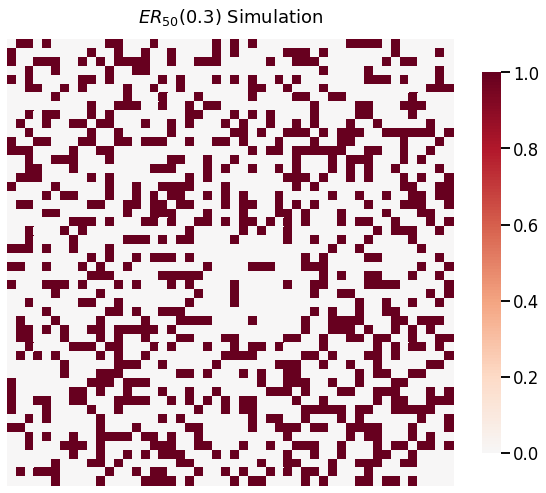

In [8]:
from graspologic.plot import heatmap
from graspologic.simulations import er_np

n = 50  # network with 50 nodes
p = 0.3  # probability of an edge existing is .3

# sample a single simple adj. mtx from ER(50, .3)
A = er_np(n=n, p=p, directed=False, loops=False)

# and plot it
heatmap(A, title="$ER_{50}(0.3)$ Simulation")

Above, we visualize the network using a heatmap. The dark red squares indicate that an edge exists between a pair of vertices, and white squares indicate that an edge does not exist between a pair of vertices.

Next, let's see what happens when we use a higher edge probability, like $p=0.7$:

<AxesSubplot:title={'center':'$ER_{50}(0.7)$ Simulation'}>

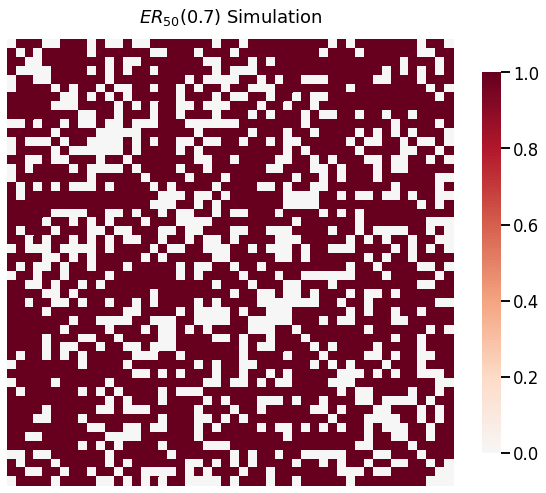

In [9]:
p = 0.7  # network has an edge probability of 0.7

# sample a single adj. mtx from ER(50, 0.7)
A = er_np(n=n, p=p, directed=False, loops=False)

# and plot it
heatmap(A, title="$ER_{50}(0.7)$ Simulation")

As the edge probability increases, the sampled adjacency matrix tends to indicate that there are more connections in the network. This is because there is a higher chance of an edge existing when $p$ is larger.

## Stochastic Block Model (SBM)

Consider the social network above. Using the ER model described above, we can only model the connections between a pair of people with a *fixed probability* that is the same for all pairs of students within the network. What would happen if we had additional information about students in our network that might influence the probability that they were friends? Consider that we know students attend one of several schools in our network. It seems fairly logical that if two students go to the same school, in general, they will probably have a higher probability of being friends than if they went to different schools. Unfortunately, using the ER model, there is nothing more complex we can do to reflect this fact. This is where the Stochastic Block Model, or SBM, comes into play. 

The SBM captures this idea through the use of a vertex-assignment vector, which assigns each of the $n$ vertices in the network to one of $K$ communities. A **community** is a group of nodes within the network. In our example case, the communities wouuld represent the schools that students are able to attend in our network. There are two flavors of SBMs: one in which the vertex-assignment vector is treated as *unknown* and one in which the vertex-assignment vector is treated as *known (it is a *vertex attribute* for the network). Across both SBM flavors, instead of describing all pairs of nodes by a fixed probability like with the ER model, in the SBM, we instead describe properties that hold for edges between *pairs of communities*. 

## A Posteriori Stochastic Block Model

In the *a posteriori* Stochastic Block Model (SBM), we consider that vertex assignment to one of $K$ communities is a random proocess. This model has the following parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $\vec \pi$ | the $K-1$ probability simplex | The probability of a vertex being assigned to community $K$ |
| $B$ | [0,1]$^{K \times K}$ | The block matrix, which assigns edge probabilities for pairs of communities |

In the *a posteriori* SBM, the vertex-assignment vector is treated as a vector-valued random variable, which is denoted by $\vec{\pmb \tau}$. In this case, $\vec{\pmb \tau}$ takes values in the space $\{1,...,K\}^n$. This means that for a given realization of $\vec{\pmb \tau}$, denoted by $\vec \tau$, that for each of the $n$ nodes in the network, we obtain an integer value between $1$ and $K$ indicating which community a node is from. Statistically, we write that the vertex assignment for node $i$, denoted by $\pmb \tau_i$, is sampled independently and identically from $Categorical(\vec \pi)$. Stated another way, the vector $\vec\pi$ indicates the probability $\pi_k$ of assignment to each community $k$ in the network.

Next, let's discuss the matrix $B$, which is known as the **block matrix** of the SBM. We write down that $B \in [0, 1]^{K \times K}$, which means that the block matrix is a matrix with $K$ rows and $K$ columns. If we have a pair of nodes and know which of the $K$ communities each node is from, the block matrix tells us the probability that those two nodes are connected. If our networks are simple, the matrix $B$ is also symmetric, which means that if $b_{k, \ell} = p$ where $p$ is a probability, that $b_{\ell, k} = p$, too. The requirement of $B$ to be symmetric exists *only* if we are dealing with simple networks, since they are undirected; if we relax the requirement of undirectedness (and allow directed networks) $B$ no longer need be symmetric.

Finally, let's think about how to write down the generative model in the *a posteriori* SBM. We showed above the model for the random vertex-assignment variable, $\vec{\pmb \tau}$, above. The model for edges of the *a posteriori* SBM is, in fact, conditional on the assignments obtained through this procedure. We write down that, conditioned on $\pmb \tau_i = \ell$ and $\pmb \tau_j = k$, that if $i > j$, $\mathbf a_{ij}$ is sampled independently from a $Bern(b_{\ell,k})$ distribution. What this reflects is the idea that, if node $i$ is in community $\ell$ and node $j$ is in community $k$, that the $(\ell,k)$ entry of the block matrix $B$ indicates the probability that nodes $i$ and $j$ are connected. Like the ER model, the edges are still independent, which means that edges occuring or not occuring do not have an impact on one another. Unlike above, we can no longer say that the $\mathbf a_{ij}$s are identically distributed, since the probability $b_{\ell, k}$ depends on the communities that nodes $i$ and $j$ are assigned to. This means that if we were to look at a different pair of nodes, the probability that the two nodes are connected could be different, and therefore they might not share the same distribution. If $\mathbf A$ is the adjacency matrix for an *a priori* SBM network with parameters $\vec \pi$ and $B$, we write that $\mathbf A \sim SBM_n(\vec \pi, B)$. 

What does the likelihood for the *a posteriori* SBM look like? In this case, $\theta = (\vec \pi, B)$ are the parameters for the model, so the likelihood for a realization $A$ of $\mathbf A$ is:
\begin{align*}
\mathcal L_\theta(A) &\propto \mathbb P_\theta(\mathbf A = A)
\end{align*}
Next, we use the fact that the probability that $\mathbf A = A$ is, in fact, the *marginalization* (over realizations of $\pmb \tau$) of the joint $(\mathbf A, \pmb \tau)$. In the line after that, we use Bayes' Theorem to separate the joint probability into a conditional probability and a marginal probability:
\begin{align}
    &= \int_\tau \mathbb P_\theta(\mathbf A = A, \pmb \tau = \tau)\textrm{d}\tau \nonumber\\
    &= \int_\tau \mathbb P_\theta(\mathbf A = A \big | \pmb \tau = \tau)\mathbb P_\theta(\pmb \tau = \tau)\textrm{d}\tau
\end{align}
Let's think about each of these probabilities separately. Remember that for $\pmb \tau$, that each entry $\pmb \tau_i$ is sampled *independently and identically* from $Categorical(\vec \pi)$.The probability mass for a $Categorical(\vec \pi)$-valued random variable is $\mathbb P(\pmb \tau_i = \tau_i; \vec \pi) = \pi_{\tau_i}$. Finally, note that if we are taking the products of $n$ $\pi_{\tau_i}$ terms, that many of these values will end up being the same. Consider, for instance, if the vector $\tau = [1,2,1,2,1]$. We end up with three terms of $\pi_1$, and two terms of $\pi_2$, and it does not matter which order we multiply them in. Rather, all we need to keep track of are the counts of each $\pi$. term. Written another way, we can use the indicator that $\tau_i = k$, given by $\mathbb 1_{\tau_i = k}$, and a running counter over all of the community probability assignments $\pi_k$ to make this expression a little more sensible. We will use the symbol $n_k = \sum_{i = 1}^n \mathbb 1_{\tau_i = k}$ to denote this value:
\begin{align*}
\mathbb P_\theta(\pmb \tau = \tau) &= \prod_{i = 1}^n \mathbb P_\theta(\pmb \tau_i = \tau_i)\;\;\;\;\textrm{Independence Assumption} \\
&= \prod_{i = 1}^n \pi_{\tau_i} \;\;\;\;\textrm{p.m.f. of a Categorical R.V.}\\
&= \prod_{k = 1}^K \pi_{k}^{n_k}
\end{align*}
Next, let's think about the conditional probability term, $\mathbb P_\theta(\mathbf A = A \big | \pmb \tau = \tau)$. Remember that the entries are all independent conditional on $\pmb \tau$ taking the value $\tau$. This means that we can separate the probability of the entire $\mathbf A = A$ into the product of the probabilities edge-wise. Further, remember that conditional on $\pmb \tau_i = \ell$ and $\pmb \tau_j = k$, that $\mathbf a_{ij}$ is $Bern(b_{\ell,k})$. The distribution of $\mathbf a_{ij}$ does *not* depend on any of the other entries of $\pmb \tau$. Remembering that the probability mass function of a Bernoulli R.V. is given by $\mathbb P(\mathbf a_{ij}=a_{ij}; p) = p^{a_{ij}}(1 - p)^{a_{ij}}$, this gives:
\begin{align*}
\mathbb P_\theta(\mathbf A = A \big | \pmb \tau = \tau) &= \prod_{i > j}\mathbb P_\theta(\mathbf a_{ij} = a_{ij} \big | \pmb \tau = \tau)\;\;\;\;\textrm{Independence Assumption} \\
&= \prod_{i > j}\mathbb P_\theta(\mathbf a_{ij} = a_{ij} \big | \pmb \tau_i = \ell, \pmb \tau_j = k) \;\;\;\;\textrm{$\mathbf a_{ij}$ depends only on $\tau_i$ and $\tau_j$}\\
&= \prod_{i > j} b_{\ell k}^{a_{ij}} (1 - b_{\ell k})^{1 - a_{ij}}
\end{align*}
Again, we can simplify this expression a bit. Recall the indicator function above. Let $|\mathcal E_{\ell k}| = \sum_{i > j}\mathbb 1_{\tau_i = \ell}\mathbb 1_{\tau_j=k}a_{ij}$, and let $n_{\ell k}= \sum_{i>j}\mathbb 1_{\tau_i = \ell}\mathbb 1_{\tau_j = k}$. Note that $\mathcal E_{\ell k}$ is the number of edges between nodes in community $\ell$ and community $k$, and $n_{\ell k}$ is the number of *possible* edges between nodes in community $\ell$ and community $k$. This expression can be simplified to:
\begin{align*}
\mathbb P_\theta(\mathbf A = A \big | \pmb \tau = \tau) &= \prod_{\ell,k} b_{\ell k}^{|\mathcal E_{\ell k}|}(1 - b_{\ell k})^{n_{\ell k} - |\mathcal E_{\ell k}|}
\end{align*}

Combining these into the integrand:
\begin{align*}
\mathcal L_\theta(A) &\propto \int_\tau \mathbb P_\theta(\mathbf A = A \big | \pmb \tau = \tau) \mathbb P_\theta(\pmb \tau = \tau)\textrm{d}\tau \\
&= \int_\tau \prod_{k = 1}^K \pi_k^{n_k}\cdot \prod_{\ell,k} b_{\ell k}^{|\mathcal E_{\ell k}|}(1 - b_{\ell k})^{n_{\ell k} - |\mathcal E_{\ell k}|}\textrm{d}\tau
\end{align*}

<!-- TODO: return to add equivalence classes -->

## A Priori Stochastic Block Model

The *a priori* SBM is very similar to the *a posteriori* SBM, with the caveat that whereas in the *a posteriori* SBM we only knew the probabilities of assignment $\vec \pi$, here we know the vertex assignments $\vec \tau$ *a priori*. The *a priori* SBM and has the following two parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $\vec\tau$ | {1,...,K}$^n$ | The community assignment vector for each of the $n$ nodes to one of $K$ communities |
| $B$ | [0,1]$^{K \times K}$ | The block matrix, which assigns edge probabilities for pairs of communities |

We write that $\vec \tau \in \{1, ..., K\}^n$, which means that $\vec \tau$ is an $n$-dimensional vector which takes one of $K$ possible values. In our social network example, for instance, this vector would reflect the fact that each of the $n$ students in our network could be attendees at one of $K$ possible schools. For a single node $i$ that is in community $\ell$, where $\ell \in \{1, ..., K\}$, we write that $\tau_i = \ell$. 

The matrix $B$ behaves exactly the same as it did with the *a posteriori* SBM. Finally, let's think about how to write down the generative model for the *a priori* SBM. Remember that $\vec \tau$ and $\pmb B$ are parameters, which means that when we fit a SBM, we know these ahead of time. Intuitionally what we want to reflect is, if we know that node $i$ is in community $\ell$ and node $j$ is in community $k$, that the $(\ell, k)$ entry of the block matrix is the probability that $i$ and $j$ are connected. We write this statement down by saying that for $i > j$, $\mathbf a_{ij}$ conditioned on $\tau_i = \ell$ and $\tau_j = k$ is sampled independently from a $Bern(b_{\ell, k})$ distribution.  If $\mathbf A$ is an *a priori* SBM network with parameters $\vec \tau$ and $B$, we write that $\mathbf A \sim SBM_n(\vec \tau, B)$.

What does the likelihood for the *a priori* SBM look like? Fortunately, since $\vec \tau$ is a *parameter* of the *a priori* SBM, the likelihood is a bit simpler than for the *a posteriori* SBM. This is because the *a posteriori* SBM requires a marginalization over potential realizations of $\vec{\pmb \tau}$, whereas the *a priori* SBM does not. The likelihood is as follows, omitting detailed explanations of steps that are described above:
\begin{align*}
\mathcal L_\theta(A) &\propto \mathbb P_{\theta}(\mathbf A = A) \\
&= \prod_{i > j} \mathbb P_\theta(\mathbf a_{ij} = a_{ij})\;\;\;\;\textrm{Independence Assumption} \\
&= \prod_{i > j} b_{\ell k}^{a_{ij}}(1 - b_{\ell k})^{1 - a_{ij}}\;\;\;\;\textrm{p.m.f. of Bernoulli distribution} \\
&= \prod_{k, \ell}b_{\ell k}^{|\mathcal E_{\ell k}|}(1 - b_{\ell k})^{n_{\ell k} - |\mathcal E_{\ell k}|}
\end{align*}

Like the ER model, there are again equivalence classes of the sample space $\mathcal A_n$ in terms of their likelihood. Let $|\mathcal E_{\ell k}(A)|$ denote the number of edges in the $(\ell, k)$ block of adjacency matrix $A$. For a two-community setting, with $\vec \tau$ and $B$ given, the equivalence classes are the sets:
\begin{align*}
    E_{a,b,c} &= \left\{A \in \mathcal A_n : \mathcal E_{11}(A) = a, \mathcal E_{21}=\mathcal E_{12}(A) = b, \mathcal E_{22}(A) = c\right\}
\end{align*}
In fact, there are equivalence classes for many possible community settings, not just the two-community setting given above. We have equivalence classes for all $K$-community settings, for $K$ going from $1$ (all nodes are in the same community, identical to the ER equivalence classes) to $n$ (each node is in a *unique* community, identical to the Inhomogeneous ER equivalence classes, explained later). As before, we have the following. For any $\vec \tau$ and $B$:
1. If $A, A' \in E_{a,b,c}$ (that is, $A$ and $A'$ are in the same equivalence class), $\mathcal L_\theta(A) = \mathcal L_\theta(A')$, and
2. If $A \in E_{a, b, c}$ but $A' \in E_{a', b', c'}$ where either $a \neq a', b \neq b'$, or $c \neq c'$, then $\mathcal L_\theta(A) \neq \mathcal L_\theta(A')$.

## Code Examples

We just covered a lot of intuition that will be critical for understanding many of the later models, so let's work through an example. Let's assume that we have $300$ students, and we know that each student goes to $1$ of $2$ possible schools. We will begin by thinking about the *a priori* SBM, since it's a little more straightforward to generate samples. We don't really care too much about the ordering of the students for now, so let's just assume that the students are organized such that the first $150$ students all go to school $1$, and the second $150$ students all go to school $2$. Let's assume that the students from school $1$ are a little bit more closely knit than the students from school $2$, so we'll say that the probability of two students who both go to school $1$ being connected is $0.5$, and the probability of two students who both go to school $2$ being friends is $0.3$. Finally, let's assume that if one student goes to school $1$ and the other student goes to school $2$, that the probability that they are friends is $0.2$.

```{admonition} Thought Exercise

Before you read on, try to think to yourself about what the community assignment vector $\vec \tau$ and the block matrix $\pmb B$ look like.
```

Next, let's plot what $\vec \tau$ and $\pmb B$ look like:

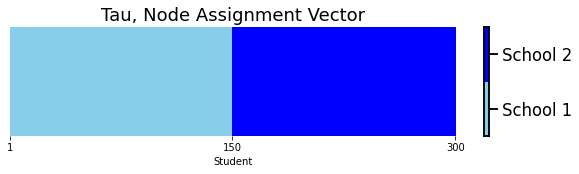

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

def plot_tau(tau, title="", xlab="Node"):
    cmap = matplotlib.colors.ListedColormap(["skyblue", 'blue'])
    fig, ax = plt.subplots(figsize=(10,2))
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap((tau - 1).reshape((1,tau.shape[0])), cmap=cmap,
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, .75])
        cbar.set_ticklabels(['School 1', 'School 2'])
        ax.set(xlabel=xlab)
        ax.set_xticks([.5,149.5,299.5])
        ax.set_xticklabels(["1", "150", "300"])
        cbar.ax.set_frame_on(True)
    return

n = 300  # number of students

# tau is a column vector of 150 1s followed by 50 2s
# this vector gives the school each of the 300 students are from
tau = np.vstack((np.ones((int(n/2),1)), np.full((int(n/2),1), 2)))

plot_tau(tau, title="Tau, Node Assignment Vector",
        xlab="Student")

So as we can see, the first $50$ students are from school $1$, and the second $50$ students are from school $2$. Next, let's look at the block matrix $B$: 

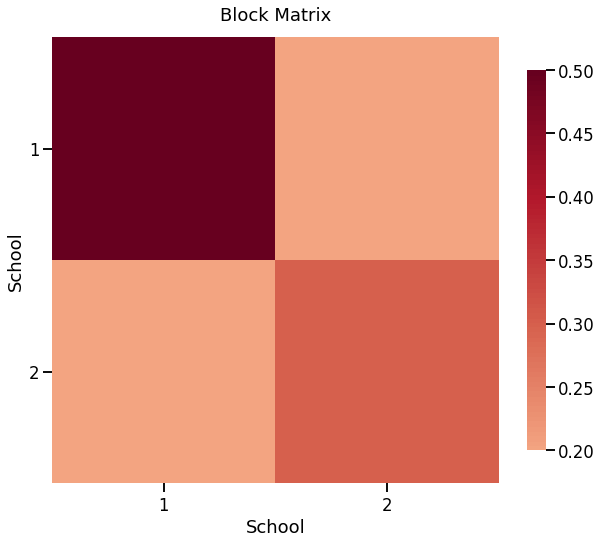

In [25]:
K = 2  # 2 communities in total
# construct the block matrix B as described above
B = np.zeros((K, K))
B[0,0] = .5
B[0,1] = B[1,0] = .2
B[1,1] = .3

ax = heatmap(B, title="Block Matrix")
ax.set_xlabel("School")
ax.set_ylabel("School")
ax.set_xticks([.5,1.5])
ax.set_xticklabels(["1", "2"])
ax.set_yticks([.5,1.5])
ax.set_yticklabels(["1","2"])
plt.show()

As we can see, the matrix $B$ is a symmetric block matrix, since our network is undirected. Finally, let's sample a single network from the SBM with parameters $\vec \tau$ and $B$:

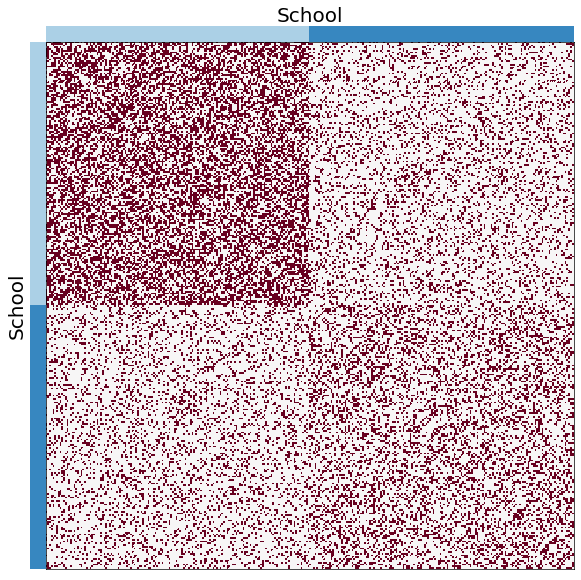

In [27]:
from graspologic.simulations import sbm
from graspologic.plot import adjplot
import pandas as pd

# sample a graph from SBM_{300}(tau, B)
A = sbm(n=[int(n/2), int(n/2)], p=B, directed=False, loops=False)
meta = pd.DataFrame(
    data = {"School": tau.reshape((n)).astype(int)}
)

ax=adjplot(A, meta=meta, color="School", palette="Blues")

The above network shows students, ordered by the school they are in (school 1 and school 2, respectively). As we can see in the above network, people from school $1$ are more connected than people from school $2$.  We notice this from the fact that there are more connections between people from school $1$ than from school $2$. Also, the connections between people from different schools appear to be a bit *more sparse* (fewer edges) than connections betwen schools. The above heatmap can be described as **modular**: it has clearly delineated communities, which are the vertices that comprise the obvious "squares" in the above adjacency matrix.

Something easy to mistake about the SBM is that the SBM will *not always* have the obvious modular structure defined above when we look at a heatmap. Rather, this modular structure is *only* made obvious because the students are ordered according to the school in which they are in. What do you think will happen if we look at the students in a random order? Do you think it will be obvious that the network will have a modular structure?

The answer is: *No!* Let's see what happens when we use an reordering, called a *permutation* of the nodes, to reorder the nodes from the network into a random order:

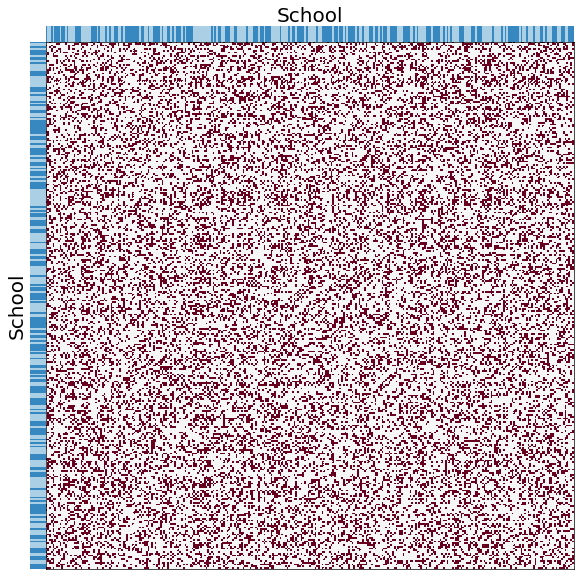

In [28]:
import numpy as np

# generate a permutation of the n vertices
vtx_perm = np.random.choice(n, size=n, replace=False)

meta = pd.DataFrame(
    data = {"School": tau[vtx_perm].reshape((n)).astype(int)}
)

# same adjacency matrix (up to reorder of the vertices)

ax=adjplot(A[tuple([vtx_perm])] [:,vtx_perm], meta=meta, color="School", palette="Blues")

Notice that now, the students are *not* organized according to school. We can see this by looking at the school assignment vector, shown at the left and top, of the network. In this sense, it becomes pretty tough in practice to figure out whether there are communities in our network just by looking at an adjacency matrix, unless you are looking at a network in which the nodes are *already arranged* in an order which respects the community structure. 

In practice, this means that if you know ahead of time what natural groupings of the nodes might be (such knowing which school each student goes to) by way of your node metadata, you can visualize your data according to that grouping. If you don't know anything about natural groupings of nodes, however, we are left with the problem of *estimating community structure*. A later method, called the *spectral embedding*, will be paired with clustering techniques to allow us to estimate vertex assignment vectors.

## Random Dot Product Graph (RDPG)

## Generalized Random Dot Product Graph (GRDPG)

## Degree-Corrected Models

## Structured Independent Edge Model (SIEM)

## Inhomogeneous Erdos-Renyi (IER)

# References

[1] Erd&ouml;s P, R&eacute;nyi A. 1959. "On random graphs, I." Publ. Math. Debrecen 6:290–297.
